In [74]:
import pandas as pd
import numpy as np

In [2]:
forecasted_info = pd.read_csv("ForecastedInformation.csv")

### Helper Functions for Differential Evolution

In [ ]:
# Creates a population with population size rows and 2N columns (1 for each parameter)
def initialize_population(bounds, population_size):
    population = np.zeros((population_size, len(bounds)))
    for i in range(len(bounds)):
        population[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], population_size)
    return population



In [ ]:
def mutate(individual_index, population, mutation_factor, bounds):
    indices = np.array([i for i in range(len(population)) if i != individual_index])
    selected_indices = np.random.choice(indices, 3, replace=False)
    a, b, c = population[selected_indices[0]], population[selected_indices[1]], population[selected_indices[2]]
    mutant = a + mutation_factor * (b - c)
    mutant = np.clip(mutant, [bound[0] for bound in bounds], [bound[1] for bound in bounds])
    return mutant

In [8]:
def crossover(target, mutant, crossover_prob):
    # Generate a mask based on the crossover probability
    mask = np.random.rand(len(target)) < crossover_prob
    # Apply the mask to choose elements from the mutant
    trial = np.where(mask, mutant, target)
    return trial

In [9]:
def differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover):
    # Initialize population and maintain current fitnesses
    population = initialize_population(parameter_bounds, population_size)
    fitness = np.array([objective_function(individual) for individual in population])

    for _ in range(n_generations):
        
        new_population = population.copy()
        for i in range(population_size):
            # Mutation
            mutant = mutate(i, population, mutation_factor, parameter_bounds)
            # Crossover
            trial = crossover(population[i], mutant, p_crossover)
            # Evaluation
            trial_fitness = objective_function(trial)
            if trial_fitness > fitness[i]:
                new_population[i] = trial
                fitness[i] = trial_fitness
    best_index = np.argmax(fitness)
    return population[best_index], fitness[best_index]

### Inputs to the function

In [4]:
# Generate bounds for each SKU
num_skus = len(forecasted_info["Pcode"].unique())

# Policy decision period
max_order_frequency = 10 # In weeks, this is up to the user!

# Parameters are a 2*num_skus by 2 matrix
# Each entry contains array of upper and lower bound
parameter_bounds = np.zeros((2*num_skus, 2))
# All lower bounds remain 0
for i, sku in enumerate(forecasted_info["Pcode"].unique()):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    parameter_bounds[2*i][1] = int(temp_df["Quantity Sold"].max())
    parameter_bounds[2*i+1][1] = max_order_frequency

# Some additional hyperparameters to tune of differential evolution
population_size = 100 
n_generations = 100 # This is QUITE susceptible to change
mutation_factor = 1 # This has to be a constant from 0 to 2
p_crossover = 0.3 # between 0 and 1

### Define objective functions and variables that it needs

In [5]:
# Variable definitions
num_skus = num_skus # As defined above
policy_optimization_period = 5 # Should equal max_order_frequency from above
df = forecasted_info # Contains all info about each sku
# Should convert it into the following form:
skus = forecasted_info["Pcode"].unique()
# Then convert this into the forms we want for optimization
prices = np.zeros((num_skus, 1))
forecast_weeks = [104, 105, 106, 107, 108] # Somehow, need to relate this to policy optimization period
quantities = np.zeros((num_skus, len(forecast_weeks)))
for j, sku in enumerate(skus):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    prices[j] = (temp_df.iloc[0]["Price"][1:])
    # ELIZA TODO: figure out why accidentally created duplicates when created the forecasted information df
    quantity_df = temp_df[temp_df["Week"].isin(forecast_weeks)].iloc[0:len(forecast_weeks)]
    quantities[j] = np.array(quantity_df["Quantity Sold"])
# NOW: prices and quantities have the info we need

In [73]:
# Define objective function based on values above
def f(individual):
    # Individual is a list of 2N values which is parameters for each SKU in the space
    # Combination of 1) Missed Sales 2) Inventory 3) Cost of buying stuff

    # Calculation of Missed Sales

    # For each SKU, start with first order simulation by getting even individual entries
    sku_quantities = np.zeros((num_skus, 1))
    frequencies = individual[1::2]
    # Then starting at the first week, try to enact the policy
    missed_sales = 0
    inventory = 0
    reorder_cost = 0
    for i in range(0, policy_optimization_period): 
        # Calculate the amount from that week from the df
        # Subtract it from the sku_quantity
        for j in range(num_skus):
            # Account for potential restock (but don't double count the first week)
            if frequencies[j] % i == 0:
                sku_quantities[j] += individual[2*j] # Add the amount from reorder

                # Cost of buying stuff (reorder_cost)
                # TODO: Sidd, can you change the costs to be nonzero amounts even though we would fabricate this data somehow
                # NOTE: I am currently pretending the cost is just 1
                reorder_cost += 1 # Here, instead, we would just do cost[j] or whever but we need a cost array

            # quantities j i is the amount of sku j sold in week i
            sku_quantities[j] = sku_quantities[j] - quantities[j][i]
            if sku_quantities[j] < 0:
                missed_sales += (-1)*sku_quantities[j]*prices[j] #-1 because sku quantities is negative here and we add to missed sales
                sku_quantities[j] = 0

        # This just calculates the inventory quantity
        inventory += sum(sku_quantities) # TODO Sidd- you can add all your notes about how much space each takes up and whatever here
    
    return missed_sales + inventory + reorder_cost

In [53]:
#### DIFFERENTIAL EVOLUTION INPUTS ####
objective_function = f
parameter_bounds = parameter_bounds
populationSize = population_size
n_generations = n_generations
mutation_factor = mutation_factor
p_crossover = 0.3

best_parameters, score = differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover)

print (best_parameters, score)

C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\3888204175.py:16: RuntimeWarning: divide by zero encountered in remainder
  restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)


[174.76157464  10.           0.         ...  10.           0.
   0.        ] 11687047.33493526


In [27]:
print (best_parameters, score)

[229.07947312   8.45946037  86.24246842 ...   8.99518016 631.67895432
   2.4105119 ] [11454984.49902288]


Next steps
(Sidd, def do the ones I put your name by and hopefully the rest of them too except for 5 lol)
(also, currently takes 2.5 minutes to run which def we cld cut down! compare to this number for stats)
1. Make the objective function significantly faster (remove for loops)
2. Figure out how to use numpy to remove the inner for loop in the algorithm
3. (Sidd) allow the inventory and reorder cost to take in the volumes and cost of reordering each indiviudal item / fix them if they are not how u want them
4. Implement hyperparameter search– what does this mean? For populationSize, n_generations, mutation_factor and p_crossover, run the algorithm for a grid of specific quantities and find the best set of these configurations that allow for lowest score (we have to be careful about the best way to do this, might be some sort of optimization as well– Sidd you can think through this)
5. (Eliza) figure out why the ForecastedInformation.csv has duplicates lol (I just removed them for now)
6. Benchmark our progress– not sure how we would do this– lmk what you think Sidd

NOTE: user inputs
- policy_optimization_period
- forecast_weeks (which exact weeks of df we are forecasting)

## Sidd notes:

- Initial run (no changes to code): 8.25 mins


In [80]:
def initialize_population(bounds, population_size):
    bounds = np.array(bounds)  # Convert bounds to a NumPy array
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    population = np.random.uniform(lower_bounds, upper_bounds, (population_size, len(bounds)))
    return population

In [87]:
def differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover):
    # Initialize population and current fitnesses
    population = initialize_population(parameter_bounds, population_size)
    fitness = np.apply_along_axis(objective_function, 1, population)

    bounds_array = np.array(parameter_bounds)  # Convert bounds to a NumPy array
    lower_bounds, upper_bounds = bounds_array[:, 0], bounds_array[:, 1]

    for _ in range(n_generations):
        # Mutation and crossover in a vectorized manner
        indices = np.arange(population_size)
        a_indices = np.random.choice(indices, size=population_size, replace=True)
        b_indices = np.random.choice(indices, size=population_size, replace=True)
        c_indices = np.random.choice(indices, size=population_size, replace=True)

        # Ensure indices are not equal to the current individual
        valid = a_indices != indices
        a_indices[~valid] = (a_indices[~valid] + 1) % population_size

        # Calculate mutants
        a, b, c = population[a_indices], population[b_indices], population[c_indices]
        mutants = a + mutation_factor * (b - c)
        mutants = np.clip(mutants, lower_bounds, upper_bounds)

        # Perform crossover
        crossover_mask = np.random.rand(population_size, len(parameter_bounds)) < p_crossover
        trial_population = np.where(crossover_mask, mutants, population)

        # Evaluate the new population in a vectorized manner
        trial_fitness = np.apply_along_axis(objective_function, 1, trial_population)

        # Update population and fitness where trial is better
        for i in range(population_size):
            if trial_fitness[i] < fitness[i]:
                population[i] = trial_population[i]
                fitness[i] = trial_fitness[i]

    best_index = np.argmax(fitness)
    return population[best_index], fitness[best_index]


In [82]:
# Generate bounds for each SKU
num_skus = len(forecasted_info["Pcode"].unique())

# Policy decision period
max_order_frequency = 10 # In weeks, this is up to the user!

# Parameters are a 2*num_skus by 2 matrix
# Each entry contains array of upper and lower bound
parameter_bounds = np.zeros((2*num_skus, 2))
# All lower bounds remain 0
for i, sku in enumerate(forecasted_info["Pcode"].unique()):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    parameter_bounds[2*i][1] = int(temp_df["Quantity Sold"].max())
    parameter_bounds[2*i+1][1] = max_order_frequency

# Some additional hyperparameters to tune of differential evolution
population_size = 100 
n_generations = 100 # This is QUITE susceptible to change
mutation_factor = 1 # This has to be a constant from 0 to 2
p_crossover = 0.3 # between 0 and 1

In [83]:
# Variable definitions
num_skus = num_skus # As defined above
policy_optimization_period = 5 # Should equal max_order_frequency from above
df = forecasted_info # Contains all info about each sku
# Should convert it into the following form:
skus = forecasted_info["Pcode"].unique()
# Then convert this into the forms we want for optimization
prices = np.zeros((num_skus, 1))
forecast_weeks = [104, 105, 106, 107, 108] # Somehow, need to relate this to policy optimization period
quantities = np.zeros((num_skus, len(forecast_weeks)))
for j, sku in enumerate(skus):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    prices[j] = (temp_df.iloc[0]["Price"][1:])
    # ELIZA TODO: figure out why accidentally created duplicates when created the forecasted information df
    quantity_df = temp_df[temp_df["Week"].isin(forecast_weeks)].iloc[0:len(forecast_weeks)]
    quantities[j] = np.array(quantity_df["Quantity Sold"])
# NOW: prices and quantities have the info we need

In [84]:
prices_flat = prices.ravel()

def f(individual):
    # Extract reorder quantities and frequencies from the individual
    reorder_quantities = np.array(individual[0::2], dtype=np.float64)
    reorder_frequencies = np.array(individual[1::2], dtype=int)

    # Initialize SKU quantities and costs
    sku_quantities = np.zeros((policy_optimization_period, num_skus))  # Stock levels over time
    missed_sales = np.zeros(num_skus)  # Missed sales per SKU
    inventory = np.zeros(policy_optimization_period)  # Inventory levels over time
    reorder_cost = np.zeros(num_skus)  # Reorder costs

    # Create a matrix of time steps
    time_steps = np.arange(1, policy_optimization_period + 1).reshape(-1, 1)

    # Determine restock weeks for all SKUs
    restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)
    
    # print("Restock Mask:", restock_mask)

    reorder_amounts = restock_mask * reorder_quantities  # Quantities restocked

    # Add reorder amounts to the inventory over time
    sku_quantities += np.cumsum(reorder_amounts, axis=0)

    # Subtract demand week by week
    demand_matrix = quantities.T  # Time × SKUs
    sku_quantities -= demand_matrix

    # Calculate missed sales where stock is negative
    missed_stock = np.minimum(sku_quantities, 0)  # Negative values indicate shortfall
    missed_sales += np.sum(-missed_stock * prices_flat, axis=0)  # Broadcast prices correctly
    sku_quantities = np.maximum(sku_quantities, 0)  # Reset negative stock to zero

    # Calculate reorder costs
    reorder_cost += np.sum(restock_mask, axis=0)  # Count reorder events

    # Calculate inventory cost as total stock across all weeks
    inventory += np.sum(sku_quantities, axis=1)  # Sum stock across SKUs

    # Return the total cost: missed sales + inventory holding + reorder costs
    total_cost = np.sum(missed_sales, dtype=np.float64) + np.sum(inventory, dtype=np.float64) + np.sum(reorder_cost, dtype=np.float64)
    return total_cost


In [90]:
#### DIFFERENTIAL EVOLUTION INPUTS ####
objective_function = f
parameter_bounds = parameter_bounds
populationSize = population_size
n_generations = n_generations
mutation_factor = mutation_factor
p_crossover = 0.3

best_parameters, score = differential_evolution(objective_function, parameter_bounds, population_size, n_generations, mutation_factor, p_crossover)

print (best_parameters, score)

C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1752546027.py:18: RuntimeWarning: divide by zero encountered in remainder
  restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)


[ 70.51860841   2.61501963 414.09476512 ...   1.70772969 408.5747203
   6.19708216] 8976549.185384043


C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1685802291.py:28: RuntimeWarning: divide by zero encountered in scalar remainder
  if week % reorder_frequencies[sku] == 0:
C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1685802291.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  np.ceil(policy_optimization_period / freq) * qty * prices[sku]
C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1685802291.py:61: RuntimeWarning: divide by zero encountered in scalar remainder
  if week % reorder_frequencies[sku] == 0:


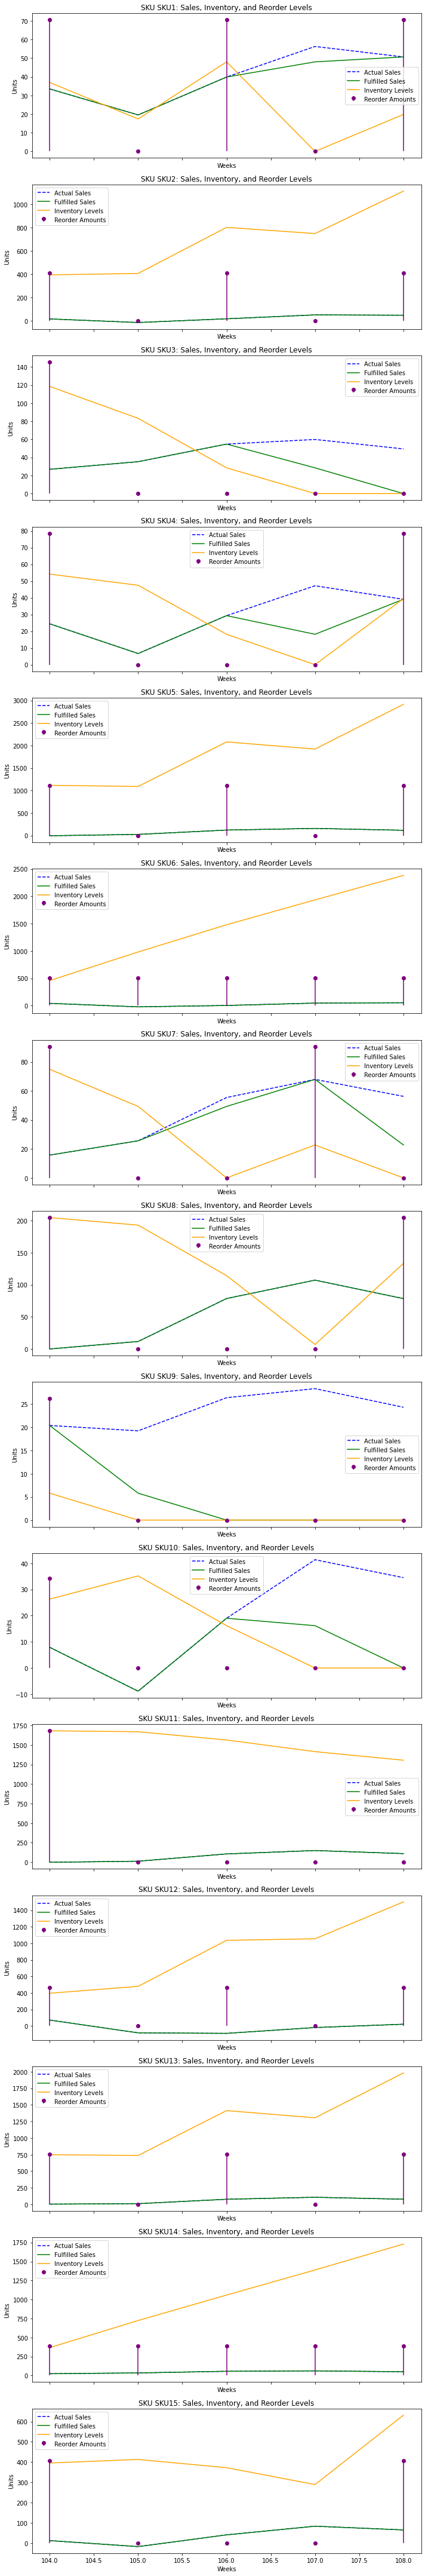

In [92]:
# Extract reorder quantities and frequencies from best_parameters
reorder_quantities = np.array(best_parameters[0::2])  # Optimal reorder quantities
reorder_frequencies = np.array(best_parameters[1::2], dtype=int)  # Optimal reorder frequencies

# Extract SKUs and relevant data from `forecasted_info`
skus = forecasted_info["Pcode"].unique()  # Unique SKUs
num_skus = len(skus)
policy_optimization_period = len(forecast_weeks)  # Number of weeks for optimization

# Prepare prices and quantities arrays
prices = np.zeros(num_skus)  # Price for each SKU
quantities = np.zeros((num_skus, policy_optimization_period))  # Weekly forecasted quantities for each SKU

for j, sku in enumerate(skus):
    temp_df = forecasted_info[forecasted_info["Pcode"] == sku]
    prices[j] = float(temp_df.iloc[0]["Price"][1:])  # Extract and clean price
    quantity_df = temp_df[temp_df["Week"].isin(forecast_weeks)].iloc[:policy_optimization_period]
    quantities[j] = np.array(quantity_df["Quantity Sold"])

# Simulate fulfilled sales and inventory using the optimal policy
fulfilled_sales = np.zeros_like(quantities)
inventory_levels = np.zeros((num_skus, policy_optimization_period))

for sku in range(num_skus):
    inventory = 0
    for week in range(policy_optimization_period):
        # Reorder according to optimal policy
        if week % reorder_frequencies[sku] == 0:
            inventory += reorder_quantities[sku]

        # Fulfill sales based on inventory
        fulfilled_sales[sku, week] = min(inventory, quantities[sku, week])
        inventory -= fulfilled_sales[sku, week]

        # Track inventory levels
        inventory_levels[sku, week] = inventory

# Calculate missed sales
missed_sales = np.sum(quantities - fulfilled_sales, axis=1)

# Calculate cost components
inventory_cost = np.sum(inventory_levels, axis=1)
reorder_cost = np.array([
    np.ceil(policy_optimization_period / freq) * qty * prices[sku]
    for sku, (freq, qty) in enumerate(zip(reorder_frequencies, reorder_quantities))
])
missed_sales_cost = missed_sales * prices  # Missed sales cost = missed units * price

cost_components = {
    'Missed Sales': missed_sales_cost,
    'Inventory': inventory_cost,
    'Reorder': reorder_cost,
}

# Generate facet plots to include actual sales, fulfilled sales through the policy, and projected inventory

# Prepare reorder tracking
reorder_weeks = np.zeros((num_skus, policy_optimization_period))
for sku in range(num_skus):
    for week in range(policy_optimization_period):
        if week % reorder_frequencies[sku] == 0:
            reorder_weeks[sku, week] = reorder_quantities[sku]

# Create the plots
fig, axes = plt.subplots(15, 1, figsize=(10, 4 * 15), sharex=True)

for sku, ax in enumerate(axes):
    ax.plot(forecast_weeks, quantities[sku], label="Actual Sales", color="blue", linestyle="--")
    ax.plot(forecast_weeks, fulfilled_sales[sku], label="Fulfilled Sales", color="green")
    ax.plot(forecast_weeks, inventory_levels[sku], label="Inventory Levels", color="orange")
    ax.stem(forecast_weeks, reorder_weeks[sku], label="Reorder Amounts", linefmt="purple", markerfmt="o", basefmt=" ")
    ax.set_title(f"SKU {skus[sku]}: Sales, Inventory, and Reorder Levels")
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Units")
    ax.legend()

plt.tight_layout()
plt.show()




# # 3. Missed Sales by SKU
# plt.figure()
# plt.bar(skus[:10], missed_sales)
# plt.title("Missed Sales by SKU")
# plt.xlabel("SKU")
# plt.ylabel("Total Missed Sales")
# plt.show()

# # 4. Cost Components Breakdown
# cost_sums = {k: np.sum(v) for k, v in cost_components.items()}
# plt.figure()
# plt.pie(cost_sums.values(), labels=cost_sums.keys(), autopct='%1.1f%%')
# plt.title("Cost Components Breakdown")
# plt.show()

# # 5. Total Cost Over Generations (Optional Placeholder)
# generations = np.arange(20)
# total_costs = np.random.uniform(1000, 2000, len(generations))  # Replace with actual costs if available
# plt.figure()
# plt.plot(generations, total_costs)
# plt.title("Total Cost Over Generations")
# plt.xlabel("Generation")
# plt.ylabel("Total Cost")
# plt.show()


In [94]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for each hyperparameter
    population_size = trial.suggest_int('population_size', 20, 100)
    n_generations = trial.suggest_int('n_generations', 10, 100)
    mutation_factor = trial.suggest_float('mutation_factor', 0.1, 2.0)
    p_crossover = trial.suggest_float('p_crossover', 0.1, 0.9)
    
    # Call your differential evolution function with the suggested hyperparameters
    _, score = differential_evolution(
        objective_function=f,
        parameter_bounds=parameter_bounds,
        population_size=int(population_size),
        n_generations=int(n_generations),
        mutation_factor=mutation_factor,
        p_crossover=p_crossover
    )
    return score  # The goal is to minimize this score

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # 'minimize' to minimize the score

# Optimize the objective function
study.optimize(objective, n_trials=20)  # n_trials = number of optimization iterations

# Extract best hyperparameters and score
best_hyperparameters = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_hyperparameters)
print("Best Score:", best_score)


[I 2024-11-28 03:21:42,825] A new study created in memory with name: no-name-fc90ad30-c339-4ec7-a50e-5d299570018b
C:\Users\sidrt\AppData\Local\Temp\ipykernel_18156\1752546027.py:18: RuntimeWarning: divide by zero encountered in remainder
  restock_mask = np.where(reorder_frequencies > 0, (time_steps % reorder_frequencies == 0), False)
[I 2024-11-28 03:21:43,155] Trial 0 finished with value: 8208973.011640211 and parameters: {'population_size': 42, 'n_generations': 49, 'mutation_factor': 0.3765348344201003, 'p_crossover': 0.2987560884279248}. Best is trial 0 with value: 8208973.011640211.
[I 2024-11-28 03:21:44,039] Trial 1 finished with value: 9185435.78690918 and parameters: {'population_size': 73, 'n_generations': 80, 'mutation_factor': 1.8406079050240254, 'p_crossover': 0.6754130815890524}. Best is trial 0 with value: 8208973.011640211.
[I 2024-11-28 03:21:44,156] Trial 2 finished with value: 9204525.23449603 and parameters: {'population_size': 37, 'n_generations': 20, 'mutation_fac

Best Hyperparameters: {'population_size': 27, 'n_generations': 64, 'mutation_factor': 0.1430385732507613, 'p_crossover': 0.6434535806435481}
Best Score: 6446781.363300679
